# Disassembling to t-SNE

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [14]:
os.chdir('/home/josephvergel/git/Gang_Network/Data')

In [15]:
#Hyperparameters
no_dims=2
initial_dims=50
perplexity=30.0

In [16]:
X = np.loadtxt("mnist2500_X.txt")
(n,d)=X.shape
labels = np.loadtxt("mnist2500_labels.txt")
dfX = pd.DataFrame(X)
dfX.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
#add the null vector to high-dimensionality space
#Xnull = np.zeros((n+1,d))
#Xnull[:-1,:] = X
#X = Xnull

#labelsnull = np.zeros(n+1)
#labelsnull[:-1] = labels
#labels = labelsnull

In [18]:
Xmean = np.mean(X, axis = 0)
X = np.vstack([X, Xmean])

labelsnull = np.zeros(n+1)
labelsnull[:-1] = labels
labels = labelsnull

## 1. LDR projection in $\mathbb{R}^2$ with PCA

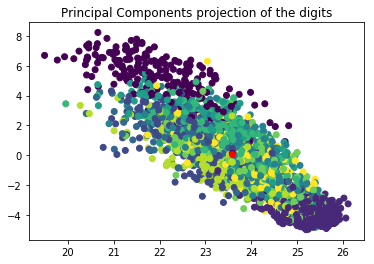

In [19]:
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis,random_projection)
X = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
(n, d) = X.shape
plt.scatter(X[:,0],X[:,1],c = labels)
plt.scatter(X[-1,0],X[-1,1],c = 'r')
plt.title("Principal Components projection of the digits")
plt.show()

In [20]:
#Initialize variables
max_iter = 1000
initial_momentum = 0.5
final_momentum = 0.8
eta = 500
min_gain = 0.01
Y = np.random.randn(n, no_dims)#standard normal distribution.
dY = np.zeros((n, no_dims))
iY = np.zeros((n, no_dims))
gains = np.ones((n, no_dims))

## 2. Computing the conditional probability

The function x2p in the original code, it calculates the similarity between high-dimensionality space elements with the "conditional probability" using

$$p_{j|i}=\frac{exp\left(-\left \| x_i - x_j \right \|^{2}/2\sigma_{i}^{2}\right)}{\sum_{i\neq k}exp\left(-\left \| x_i - x_k \right \|^{2}/2\sigma_{i}^{2}\right)}$$

In [39]:
(n, d) = X.shape
#Initialize some variables
P = np.zeros((n, n))
beta = np.ones((n, 1))
logU = np.log(perplexity)
tol=1e-5

In [52]:
#Computing the distance between rows in the X array
sum_X = np.sum(np.square(X), 1)#np.square 
p1 = -2 * np.dot(X, X.T)
p2 = np.add(p1, sum_X).T
D1 = np.add(p2, sum_X)

In [53]:
#Other method to compute the distances
#For completeness, einsum is often referenced for distance calculations.
Xt = X.reshape(X.shape[0], 1, X.shape[1])
D = np.einsum('ijk, ijk->ij', X-Xt, X-Xt)

In [54]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [55]:
for i in range(n):

    # Print progress
    if i % 500 == 0:
        print("Computing P-values for point %d of %d..." % (i, n))
    # Compute the Gaussian kernel and entropy for the current precision
    betamin = -np.inf
    betamax = np.inf
    Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
    (H, thisP) = Hbeta(Di, beta[i])

    # Evaluate whether the perplexity is within tolerance
    Hdiff = H - logU
    tries = 0
    while np.abs(Hdiff) > tol and tries < 50:
        # If not, increase or decrease precision
        if Hdiff > 0:
            betamin = beta[i].copy()
            if betamax == np.inf or betamax == -np.inf:
                beta[i] = beta[i] * 2.
            else:
                beta[i] = (beta[i] + betamax) / 2.
        else:
            betamax = beta[i].copy()
            if betamin == np.inf or betamin == -np.inf:
                beta[i] = beta[i] / 2.
            else:
                beta[i] = (beta[i] + betamin) / 2.

        # Recompute the values
        (H, thisP) = Hbeta(Di, beta[i])
        Hdiff = H - logU
        tries += 1

    # Set the final row of P
    P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
    # Return final P-matrix
print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))


Computing P-values for point 0 of 2501...
Computing P-values for point 500 of 2501...
Computing P-values for point 1000 of 2501...
Computing P-values for point 1500 of 2501...
Computing P-values for point 2000 of 2501...
Computing P-values for point 2500 of 2501...
Mean value of sigma: 0.203277


In [56]:
print(pd.DataFrame(P).shape)
pd.DataFrame(P).head()

(2501, 2501)


,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.000000e+00,0.0,1.237718e-04,0.000000e+00,2.194182e-132,1.988237e-25,0.000000e+00,7.022306e-87,0.000000e+00,1.779210e-87,...,1.135355e-73,5.046245e-313,0.000000,9.511760e-08,0.000000e+00,7.194379e-05,0.000000e+00,3.353007e-35,6.436787e-51,3.051907e-09
1,1.791365e-57,0.0,2.191972e-56,5.565630e-251,1.304633e-126,1.384782e-37,6.281625e-178,2.518571e-23,3.094062e-207,2.013310e-108,...,8.545547e-106,2.061038e-166,0.010738,6.341230e-47,5.382642e-248,5.705444e-62,2.380181e-210,2.530275e-41,1.712255e-29,5.887021e-70
2,4.113541e-05,0.0,0.000000e+00,0.000000e+00,1.562753e-152,5.951751e-36,0.000000e+00,7.543428e-108,0.000000e+00,1.850496e-94,...,6.425449e-85,0.000000e+00,0.000000,5.465857e-07,0.000000e+00,3.070803e-15,0.000000e+00,6.690428e-25,2.085927e-64,5.814376e-10
3,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.393771e-139,0.000000e+00,8.925725e-47,0.000000e+00,1.477284e-30,3.278650e-190,...,6.011374e-203,3.628467e-70,0.000000,0.000000e+00,5.587524e-02,0.000000e+00,2.588018e-13,0.000000e+00,0.000000e+00,0.000000e+00
4,9.352327e-105,0.0,3.777544e-105,2.192203e-159,0.000000e+00,1.691363e-210,8.609247e-48,0.000000e+00,1.010394e-102,1.467911e-08,...,1.436772e-08,1.543336e-46,0.000000,1.278965e-145,1.229777e-153,8.466330e-99,2.601328e-82,1.472946e-184,5.787908e-270,1.847369e-63


In [66]:
# Initialize variables
#X = pca(X, initial_dims).real
(n, d) = X.shape
max_iter = 1000
initial_momentum = 0.5
final_momentum = 0.8
eta = 500
min_gain = 0.01    
Y = np.random.randn(n, no_dims)
dY = np.zeros((n, no_dims))
iY = np.zeros((n, no_dims))
gains = np.ones((n, no_dims))

# Compute P-values
#P = x2p(X, 1e-5, perplexity)
P = P + np.transpose(P)
P = P / np.sum(P)
P = P * 4.									# early exaggeration
P = np.maximum(P, 1e-12)

# Run iterations
for iter in range(max_iter):
    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num[range(n), range(n)] = 0.
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
        dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

    # Perform the update
    if iter < 20:
        momentum = initial_momentum
    else:
        momentum = final_momentum
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
            (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y = Y + iY
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    # Compute current value of cost function
    if (iter + 1) % 10 == 0:
        C = np.sum(P * np.log(P / Q))
        print("Iteration %d: error is %f" % (iter + 1, C))

    # Stop lying about P-values
    if iter == 100:
        P = P / 4.


Iteration 10: error is 21.981838
Iteration 20: error is 18.875154
Iteration 30: error is 15.376649
Iteration 40: error is 13.772615
Iteration 50: error is 13.191439
Iteration 60: error is 12.939712
Iteration 70: error is 12.828309
Iteration 80: error is 12.669882
Iteration 90: error is 12.519469
Iteration 100: error is 12.442186
Iteration 110: error is 1.502519
Iteration 120: error is 1.325488
Iteration 130: error is 1.200072
Iteration 140: error is 1.099075
Iteration 150: error is 1.016574
Iteration 160: error is 0.949968
Iteration 170: error is 0.896271
Iteration 180: error is 0.852601
Iteration 190: error is 0.816637
Iteration 200: error is 0.786687
Iteration 210: error is 0.761539
Iteration 220: error is 0.740235
Iteration 230: error is 0.721985
Iteration 240: error is 0.706196
Iteration 250: error is 0.692428
Iteration 260: error is 0.680359
Iteration 270: error is 0.669747
Iteration 280: error is 0.660398
Iteration 290: error is 0.652138
Iteration 300: error is 0.644811
Iteration

In [61]:
#t1
Y = tsne(X, 2, 50, 20.0)


NameError: name 'pca' is not defined

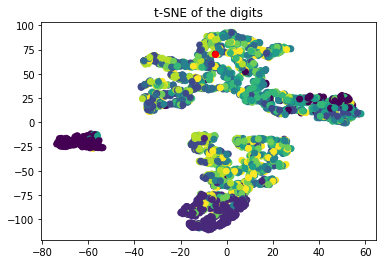

In [62]:
plt.scatter(Y[:,0],Y[:,1],c = labels)
plt.scatter(Y[-1,0],Y[-1,1],c = 'r')
plt.title("t-SNE of the digits")
plt.show()

In [64]:
#t2
X[:,0] = X[:,0]*np.random.randn(len(X))
X[:,1] = X[:,1]*np.random.randn(len(X))


In [67]:
Y = tsne(X, 2, 50, 20.0)


NameError: name 'pca' is not defined

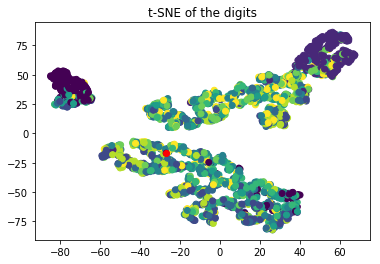

In [68]:
plt.scatter(Y[:,0],Y[:,1],c = labels)
plt.scatter(Y[-1,0],Y[-1,1],c = 'r')
plt.title("t-SNE of the digits")
plt.show()